### Salish Sea Zooplankton
Comparing monthly zooplankton biomass from Salish Sea Cast with zooplankton in Atlantis across the entire domain of both models

In [1]:
import arrow
import os
from datetime import datetime, timedelta
import itertools
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as sgeom
import xarray as xr
import ssam_groups as groups
from cartopy import crs, feature
from pathlib import Path
from IPython.display import Image
from shapely.geometry import MultiPoint
from mpl_toolkits.axes_grid1 import make_axes_locatable

from salishsea_tools import data_tools, places, nc_tools, wind_tools

### Read in SalishSeaCast monthly mean zooplankton biomass from 2007-2020 (Suchy et al., 2025)

In [2]:
# pull SalishSeaCast whole model data for all zooplankton
ssc_data_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/"
monthly_array_zoo_depthint_slicemean = pd.read_csv(ssc_data_path+"SSC201905_monthly_zoo.csv")

In [4]:
ssc_zoo_monthly_mean = monthly_array_zoo_depthint_slicemean.mean(axis=0)
ssc_zoo_std = monthly_array_zoo_depthint_slicemean.std(axis=0)

In [5]:
ssc_zoo_monthly_mean

Jan    19.707143
Feb    20.021429
Mar    27.450000
Apr    48.621429
May    65.742857
Jun    64.621429
Jul    62.514286
Aug    57.192857
Sep    51.600000
Oct    46.821429
Nov    33.828571
Dec    23.278571
dtype: float64

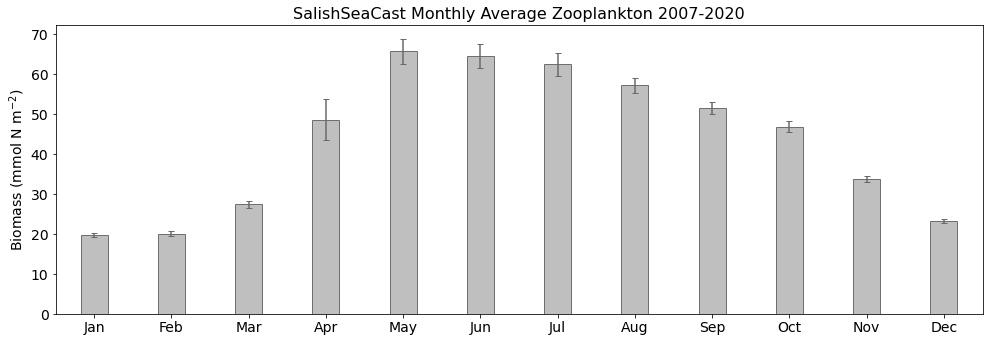

In [7]:
#Check data
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_zoo_monthly_mean)) 

width=0.35

ax.bar(xticks, ssc_zoo_monthly_mean,width,yerr=ssc_zoo_std,color='grey',ecolor='dimgrey',edgecolor='k',label='Zooplankton',alpha=0.5,capsize=3) 
#ax.bar(xticks + 0.2, ssc_mesozoo_monthly_mean,width,yerr=ssc_mesozoo_std,color='k',ecolor='grey',edgecolor='k',hatch='//',alpha=0.7,capsize=3,label='Mesozooplankton') 
ax.set_title('SalishSeaCast Monthly Average Zooplankton 2007-2020',fontsize=16)
#ax.legend(frameon=False,fontsize=14,loc="upper left")
#ax.set_ylim(0,50)
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Biomass (mmol N m$^{-2}$)',fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));

### Read in SSAM zooplankton data, 100 m depth-integrated

In [8]:
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]

<AxesSubplot:>

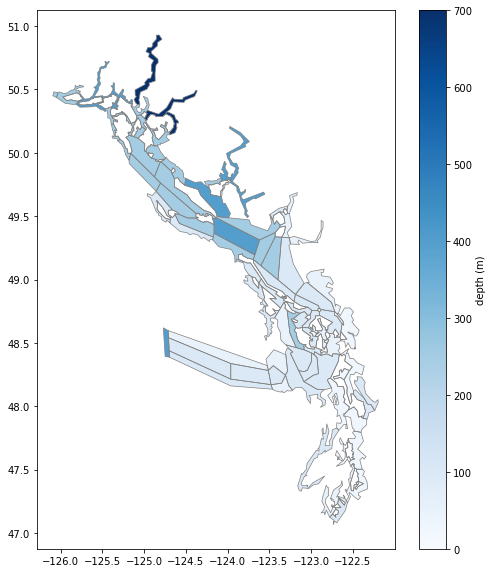

In [9]:
# Atlantis Map (whole model data)
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95)

ax = data_df.plot(column = 'BOTZ', ax=ax, cmap=cm.Blues, cax=cax,
    legend=True, legend_kwds={'label': 'depth (m)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
land_df.plot(ax=ax, color='white')

In [10]:
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/v6719_14y_20250703/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True) #.resample(t='1M').mean()


In [12]:
# pull Atlantis all model data for all zooplankton
ssam_zoo_tbl = control.Zoo_N[:, groups.salish_sea, 3:6] + control.MicroZoo_N[:, groups.salish_sea, 3:6] + control.Gelat_Zoo_N[:, groups.salish_sea, 3:6] + control.Carniv_Zoo_N[:, groups.salish_sea, 3:6]
ssam_zoo_t = ssam_zoo_tbl.sum(axis=(1,2))

In [13]:
ssam_zoo_t_corrected = (ssam_zoo_t)/(14*100)# convert to equal units

In [14]:
ssam_zoo_monthly_mean = ssam_zoo_t_corrected.groupby("t.month").mean("t")
ssam_zoo_std = ssam_zoo_t_corrected.groupby("t.month").std("t")

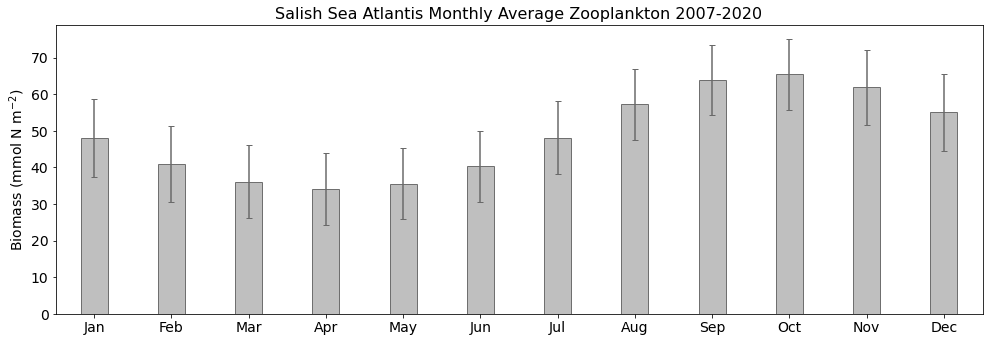

In [17]:
#Check data
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_zoo_monthly_mean)) 

width=0.35

ax.bar(xticks, ssam_zoo_monthly_mean,width,yerr=ssam_zoo_std,color='grey',ecolor='dimgrey',edgecolor='k',label='SSAM Zooplankton',alpha=0.5,capsize=3) 
ax.set_title('Salish Sea Atlantis Monthly Average Zooplankton 2007-2020',fontsize=16)
#ax.legend(frameon=False,loc='upper left',fontsize=14)
#ax.set_ylim(0,50)
#ax.set_yscale('log') #nonpositive='clip'
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Biomass (mmol N m$^{-2}$)',fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));

### Comparison figures

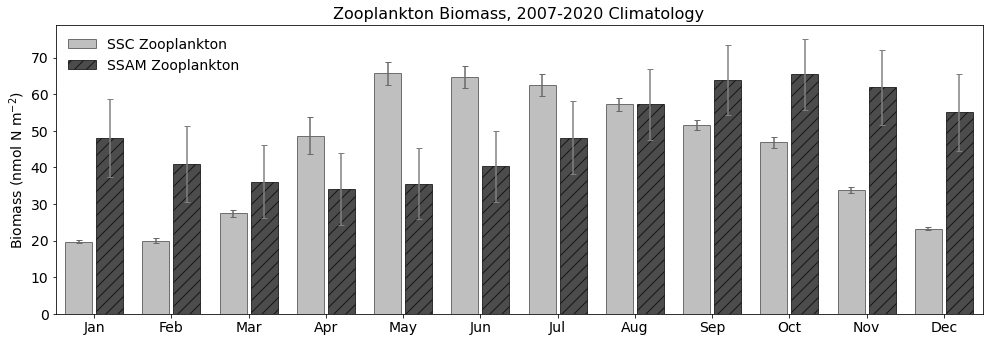

In [20]:
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_zoo_monthly_mean)) 

width=0.35

ax.bar(xticks-0.2, ssc_zoo_monthly_mean,width,yerr=ssc_zoo_std,color='grey',ecolor='dimgrey',edgecolor='k',label='SSC Zooplankton',alpha=0.5,capsize=3) #wheat
ax.bar(xticks + 0.2, ssam_zoo_monthly_mean,width,yerr=ssam_zoo_std,color='k',ecolor='grey',edgecolor='k',hatch='//',alpha=0.7,capsize=3,label='SSAM Zooplankton') #lightgreen
ax.set_title('Zooplankton Biomass, 2007-2020 Climatology',fontsize=16)
ax.legend(frameon=False,fontsize=14, loc="upper left")
#ax.set_ylim(0,50)
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Biomass (nmol N m$^{-2}$)',fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
#ax.text(-.25, 50, "(b)", color='k',fontsize=16)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));